## Extract one OC with the DBSCAN parameters

In [11]:
using PyCall
using Statistics , StatsBase
using  DataFrames, Printf

import PyPlot
sns= pyimport("seaborn")

## directory
rootdir = ENV["GAIA_ROOT"]
wdir    = "$rootdir/products"
votdir  = "$rootdir/products/votable"
plotdir = "$rootdir/products/testfull2"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering


cd(wdir)

In [12]:
function _get_OC(df , dfcart, labels , labelmax)
    ra= df.raw[1, labels[labelmax]]
    dec= df.raw[2,labels[labelmax]]
    l= df.data[1, labels[labelmax]]
    b= df.data[2,labels[labelmax]]
    d= df.data[3,labels[labelmax]]
    pmra= df.raw[6, labels[labelmax]]
    pmdec= df.raw[7, labels[labelmax]]
    X= dfcart.data[1, labels[labelmax]]
    Y= dfcart.data[2, labels[labelmax]]
    Z= dfcart.data[3, labels[labelmax]]
    vl= df.data[4,labels[labelmax]]
    vb= df.data[5,labels[labelmax]]
    vrad= df.raw[13,labels[labelmax]]
    gbar= df.raw[10,labels[labelmax]]
    rp= df.raw[11,labels[labelmax]]
    bp= df.raw[12,labels[labelmax]]
    ag= df.raw[14,labels[labelmax]]

    oc= DataFrame(ra=ra,dec=dec,l=l,b=b, distance=d,pmra=pmra, pmdec=pmdec, X=X,Y=Y,Z=Z,vl=vl,vb=vb,vrad=vrad,gbar=gbar,rp=rp,bp=bp, ag=ag)

    return(oc)
end

function _getdata(voname, wghtblck)
    data       = read_votable(voname)
    df         = filter_data(data)
    dfcart     = add_cartesian(df)
    blck       = [[1,2,3],[4,5], [6,7,8]]
    norm       = "identity"

    dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false)
    return(df, dfcart , dfcartnorm)
end

_getdata (generic function with 1 method)

In [13]:
votname= "test.vot"

w3d=  6.828378189123
wvel=  
whrd=  

wght= [w3d, wvel, whrd]
df , dfcart , dfcartnorm = _getdata(votname, wght)

eps =  2.1617344237767
min_cl  = 22
min_nei = 8


labels = clusters(dfcartnorm.data ,eps  , 20, min_nei, min_cl)
labelmax , nmax = find_cluster_label(labels)

oc= _get_OC(df , dfcart, labels , labelmax)

## Votable test.vot read
## Filtering done ...
## Stars selected: 10599
## Cartesian transformation done ...
## Normalization identity done...
### [1pc,1pc,1pc,1km/s,1km/s,1mag,1mag,1mag] equivalent to [0.3750996968492263, 0.3750996968492263, 0.3750996968492263, 0.49054797503314584, 0.49054797503314584, 0.17946775072661938, 0.17946775072661938, 0.17946775072661938]
##


,ra,dec,l,b,distance,pmra,pmdec,X,Y
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,82.4548,35.8344,172.39,0.882062,1099.74,1.98311,-4.60345,1099.68,-4.34407
2,82.3517,35.388,172.716,0.56584,1163.43,1.58287,-4.58185,1163.42,2.02391
3,82.5067,35.6869,172.537,0.835871,1145.35,1.34531,-4.52365,1145.3,-1.59912
4,82.3348,35.7455,172.411,0.751874,1093.91,1.69668,-4.0696,1093.87,-3.93091
5,82.2803,35.6168,172.493,0.643833,1137.5,1.20233,-3.93623,1137.48,-2.44493
6,82.2919,35.7121,172.419,0.704365,1135.94,1.57869,-4.62029,1135.91,-3.91248
7,82.3225,35.7343,172.414,0.737389,1081.21,1.9185,-4.30368,1081.18,-3.81353
8,82.2809,35.571,172.532,0.618935,1166.42,1.66249,-4.32505,1166.4,-1.72303
9,82.2007,35.5461,172.517,0.550795,1115.42,1.78382,-4.49363,1115.41,-1.94677


In [14]:
## plot_cluster

function _plot_oc(df)
    PyPlot.plt.figure(figsize=(13.0,12.0))

    PyPlot.plt.subplot(3, 3, 1 , xlim = [-10,10] , ylim = [-10,10])
    PyPlot.plt.scatter(df.Y .- mean(df.Y), df.Z .- mean(df.Z) , s = 1.0 )
    PyPlot.plt.xlabel("Y (pc)")
    PyPlot.plt.ylabel("Z (pc)")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 2 , ylim = [-20,20])
    PyPlot.plt.scatter(df.X, df.Z .- mean(df.Z)  , s = 1.0 )
    PyPlot.plt.xlabel("X (pc)")
    PyPlot.plt.ylabel("Z (pc)")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 4 , xlim = [-20,20])
    PyPlot.plt.scatter(df.Y .- mean(df.Y) , df.X, s = 1.0 )
    PyPlot.plt.xlabel("Y (pc)")
    PyPlot.plt.ylabel("X (pc)")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 3 )
    PyPlot.plt.scatter(df.X, df.vrad , s = 1.0 )
    PyPlot.plt.xlabel("X(pc)")
    PyPlot.plt.ylabel("Vrad (km/s)")
    PyPlot.plt.grid(true)    
        
    PyPlot.plt.subplot(3, 3, 5)
    PyPlot.plt.axis("off")
    ## text to display
    text =[]
    txt = @sprintf("N stars: %3d",length(df.X)) ; push!(text,txt)
    txt = @sprintf("Distance: %3.1f (pc)",median(df.distance)) ; push!(text,txt)
    txt = @sprintf("l: %3.3f (degree)",median(df.l)) ; push!(text,txt)
    txt = @sprintf("b: %3.3f (degree)",median(df.b)) ; push!(text,txt)  
    txt = @sprintf("Vl: %3.2f (km/s)",median(df.vl)) ; push!(text,txt) 
    txt = @sprintf("Vb: %3.2f (km/s)",median(df.vb)) ; push!(text,txt)
    txt = @sprintf("Vr: %3.2f (km/s, no masking)",median(df.vrad)) ; push!(text,txt)
    txt = @sprintf("X disp.: %3.2f (pc)", std(df.X)) ; push!(text,txt)
    txt = @sprintf("Y disp.: %3.2f (pc)", std(df.Y)) ; push!(text,txt)  
    txt = @sprintf("Z disp.: %3.2f (pc)", std(df.Z)) ; push!(text,txt)
    txt = @sprintf("Vl disp.: %3.2f (km/s)", std(df.vl)) ; push!(text,txt)
    txt = @sprintf("Vb disp.: %3.2f (km/s)", std(df.vb)) ; push!(text,txt)
    txt = @sprintf("Vr disp.: %3.2f (km/s)", std(df.vrad)) ; push!(text,txt)
    show_text(-0.01,0.0, text , 1.0)
    
    PyPlot.plt.subplot(3, 3, 7 )
    PyPlot.plt.axis("on")    
    PyPlot.plt.scatter(df.gbar-df.rp, -df.gbar , s = 1.0 )
    PyPlot.plt.xlabel("G-Rp")
    PyPlot.plt.ylabel("G")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 8 )
    PyPlot.plt.scatter(df.vl, df.vb , s = 1.0 )
    PyPlot.plt.xlabel("Vl (km/s)")
    PyPlot.plt.ylabel("Vb (km/s)")
    PyPlot.plt.grid(true)
end

_plot_oc (generic function with 1 method)

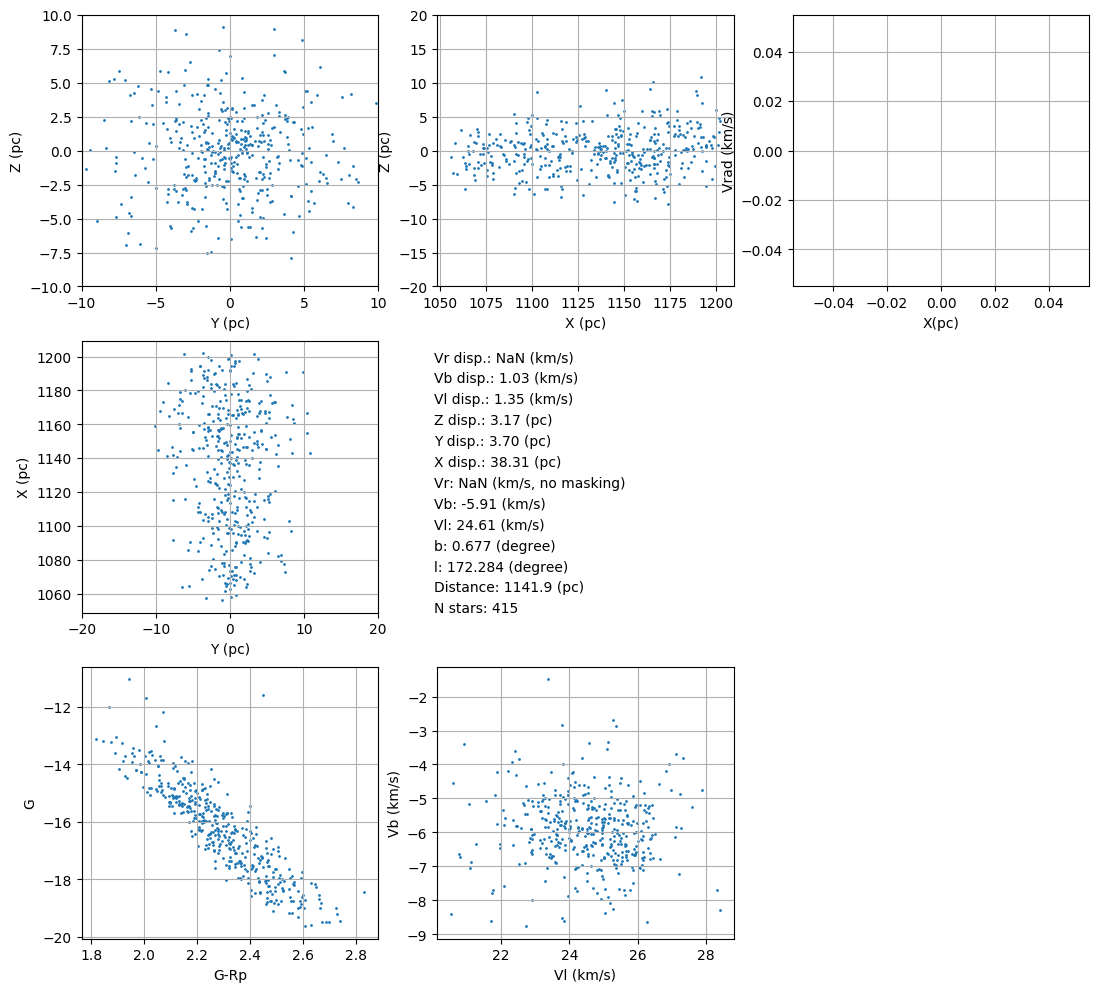

In [15]:
_plot_oc(oc)